Complete submission
1. ablation -> fix the table 3, simply use patch length 2, add define of the patch length
2. visual attack, select some of the attacks on LAMBADA and bAbI (explan the table 2 with visual attack results)
3. CBT-CN
4. compare throughput with GPT2
5. compare time/memory/#tokens comparing with GPT2 -> if we have good results.
6. why we want to do this


In [1]:
from datasets import load_dataset
from LatentPixel import LatentLlama, TGraph, DEFAULT_BINARY_RENDERING
from tqdm import tqdm
import numpy as np

import re
import subprocess
import pandas as pd
from multiprocessing import Pool
from functools import partial
import torch
import os

torch.no_grad()

import logging
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.ERROR)
    
_ = TGraph.init_render(**DEFAULT_BINARY_RENDERING)

/home/tai/data/miniconda3/envs/pixel/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


16


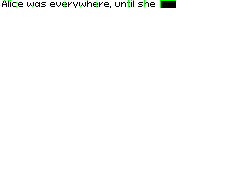

In [2]:
img = TGraph.from_text(['Alice was everywhere, until she'])
img.to_PIL(contour=0.3)[0]

In [3]:
pixar113_stage1_path = '/home/tai/src/projects/msc_project/storage/checkpoints/1MModels/dllama_2_b/backbone'
pixar113_stage2_path = '/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_10/200/backbone'

In [4]:
model1 = LatentLlama(backbone_path=pixar113_stage1_path, num_channels=1, patch_len=2, patch_size=8)
model2 = LatentLlama(backbone_path=pixar113_stage2_path, num_channels=1, patch_len=2, patch_size=8)
model1.eval().cuda()
_ = model2.eval().cuda()

Coder path is none, do not load compressor for this model
Coder path is none, do not load compressor for this model


# LAMBADA Evaluation

zero-shot performance on the test set

In [5]:
import os
def save_generated(imgs: list, dir: str) -> None:
    for i, (p, t, g) in enumerate(imgs):
        fname = f'{i}_{t}'
        pname = os.path.join(dir, fname, 'prompt')
        gname = os.path.join(dir, fname, 'gen')
        p.to_file(pname)
        g.to_file(gname)

In [6]:
from datasets import load_dataset
from LatentPixel import LatentLlama, TGraph, DEFAULT_BINARY_RENDERING
from tqdm import tqdm
import numpy as np

import re
import subprocess
import pandas as pd
from multiprocessing import Pool
from functools import partial
import torch
import os

import logging
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.ERROR)
    
torch.no_grad()

In [7]:
pat = re.compile('([a-zA-Z]+)')
def add_word(words: str | list[str], corpus: set[str]):
    global pat
    if isinstance(words, str):
        words = re.findall(pat, words)

    for word in words:
        corpus.add(str(word).lower())
    return

def _evluate(gen: tuple[TGraph, str, TGraph], vocab: set[str]) -> tuple[bool, bool, bool]:
    p, t, g = gen
    readable, pad_correct, tes_correct = False, False, False
    t = t.replace('g', 'q').lower()
    img = g[p._num_text_patches[0]-1:g._num_text_patches[0]-1]
    paddle_text = img.ocr(method='paddleocr', square=False, span=True, span_ratio=1.3, scale=3)
    tess_text = img.ocr(method='tesseract', square=False, span=True, span_ratio=1.3, scale=3)
    
    m = pat.match(paddle_text[0])
    if m is not None:
        text = m.groups()[0]
    else:
        text = ''
    if text.lower() in vocab:
        readable = True
    text.replace('g', 'q').lower()
    if text == t:
        pad_correct = True
        
    m = pat.match(tess_text[0])
    if m is not None:
        text = m.groups()[0]
    else:
        text = ''
    if text.lower() in vocab:
        readable = True
    text.replace('g', 'q').lower()
    if text == t:
        tes_correct = True
        
    return pad_correct, tes_correct, readable    

def evaluate(generated, vocab) -> tuple[float, float, float]:
    num = len(generated)
    cp, ct, c, cr = 0, 0, 0, 0
    
    with Pool(14) as p:
        results = p.map(partial(_evluate, vocab=vocab), generated)
        
    for p, t, r in results:
        if p:
            cp += 1
        if t:
            ct += 1
        if r:
            cr += 1
        if p or t:
            c += 1
            
    return cp / num, ct / num, c / num, cr / num

def evaluate_babi(generated: list, vocab: set) -> dict[str, float]:
    pat = re.compile('^([a-zA-Z]*)')
    correct_paddle = 0
    correct_tess = 0
    corrects = 0
    n_readable = 0
    for idx in tqdm(range(len(generated))):
        cor = False
        readable = False
        pro = generated[idx][0]
        t: str = generated[idx][1]
        t = t.replace('g', 'q')
        g = generated[idx][2]
        img: TGraph = g[pro._num_text_patches[0]-1:g._num_text_patches[0]-1]
        text = img.ocr(method='paddleocr', square=False, span=True, span_ratio=1.3, scale=3)
        raw = text[0].lower().split()
        if len(raw) == 0:
            raw = ''
        else:
            raw = raw[0]  
        m = pat.match(text[0])
        if m is not None:
            text = m.groups()[0]
        else:
            text = ''
        if raw in vocab:
            readable = True
        text = text.replace('g', 'q')
        if text == t:
            correct_paddle += 1
            cor = True
        text = img.ocr(method='tesseract', square=False, span=True, span_ratio=1.3, scale=3)
        raw = text[0].lower().split()
        if len(raw) == 0:
            raw = ''
        else:
            raw = raw[0]  
        m = pat.match(text[0])
        if m is not None:
            text = m.groups()[0]
        else:
            text = ''
        if raw in vocab:
            readable = True
        text = text.replace('g', 'q')
        if text == t:
            correct_tess += 1
            cor = True
        if cor:
            corrects += 1
        if readable:
            n_readable += 1
    return {
        'paddleocr': correct_paddle / len(generated),
        'tesseract': correct_tess / len(generated),
        'union': corrects / len(generated),
        'readability': n_readable / len(generated) 
    }
    
def process_lambda(raw: str) -> str:
    raw = raw.replace('`` ', '"').replace(" ''", '"').replace('``', '"').replace("''", '"')
    result = ''
    for idx in range(len(raw) - 1):
        c = raw[idx]
        cn = raw[idx + 1]
        if cn in ',.?><{}()\'' and c == ' ':
            continue
        if (raw[idx+1:idx+4] == "n't" or raw[idx+1:idx+4] == "'re" or raw[idx+1:idx+3] == "'d" or raw[idx+1:idx+3] == "'s" or raw[idx+1:idx+3] == "'m") and raw[idx] == ' ':
            continue
        if raw[idx+1] == "'" and raw[idx+2] in 'abcdefghijklmnopqrstuvwxyz' and raw[idx] == ' ':
            continue
        result += raw[idx]
    result += raw[-1]
    return result


## Load Dataset and Build the Vocabulary

In [8]:
data = load_dataset('lambada', split='test')
TGraph.init_render(**DEFAULT_BINARY_RENDERING)
corpo = pd.read_csv('storage/unigram_freq.csv')
vocab = set()
add_word(corpo.word.tolist(), vocab)
for a, b in data:
    add_word(a, vocab)
    add_word(b, vocab)
print(len(vocab))

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2662 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4869 [00:00<?, ? examples/s]

333332


In [9]:
idx = 1106
txt = data[idx]['text']
words = txt.split()
prompt = process_lambda(' '.join(words[:-1]))
prompt = TGraph.from_text([prompt])
prompt = prompt._spacing_text(3)
prompt.set_device('cuda')
target = words[-1]
gen1 = model1.autoregressive_generate(prompt, None, 4, 'gray_scale', temperature=0.1)
gen2 = model2.autoregressive_generate(prompt, None, 4, 'gray_scale', temperature=0.1)

In [10]:
target

'tabitha'

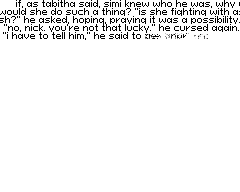

In [11]:
gen2.to_PIL(binary_method='gray_scale')[0]

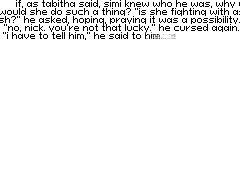

In [12]:
gen1.to_PIL(binary_method='gray_scale')[0]

In [13]:
idx = 2300
txt = data[idx]['text']
words = txt.split()
prompt = process_lambda(' '.join(words[:-1]))
prompt = TGraph.from_text([prompt])
prompt = prompt._spacing_text(3)
prompt.set_device('cuda')
target = words[-1]
gen1 = model1.autoregressive_generate(prompt, None, 4, 'gray_scale', temperature=0.1)
gen2 = model2.autoregressive_generate(prompt, None, 4, 'gray_scale', temperature=0.1)

In [14]:
target

'bastian'

In [15]:
prompt.to_file('readability/prompt')

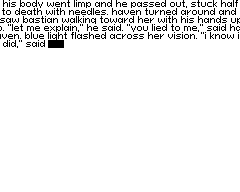

In [151]:
prompt.to_PIL()[0]

In [156]:
gen1.to_file('readability/gen1', binary_method='gray_scale')

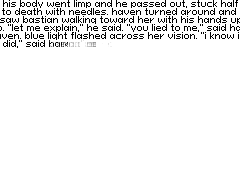

In [152]:
gen1.to_PIL(binary_method='gray_scale')[0]

In [158]:
gen2.to_file('readability/gen2', binary_method='gray_scale')

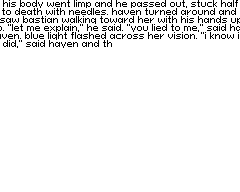

In [153]:
gen2.to_PIL(binary_method='gray_scale')[0]

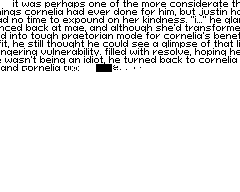

In [62]:
g1.to_PIL()[0]

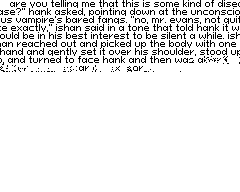

In [53]:
g2.to_PIL()[0]

## Manul Annotations of First 200 Samples

Generated by 0.1M binary model

In [7]:
capital = '1 3 5 7 8 17 19 21 23 24 26 29 30 31 33 36 38 40 41 43 48 55 57 58 59 60 61 62 65 70 72 74 76 79 80 81 82 87 88 90 93 95 96 97 99 101 104 106 110 112 115 116 117 118 120 121 122 124 126 131 132 134 138 139 141 143 145 147 148 149 150 151 154 155 157 159 160 162 164 165 166 167 172 174 176 180 181 183 186 187 189 191 192 195 197 198 199'
wrong_word = '19 21 24 58 81 88 106 182 184'
correct = '2 4 20 35 63 111 141 145'
non_text = '0 1 3 5 6 7 8 9 10 11 12 13 14 15 16 17 18 22 23 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 59 60 61 62 64 65 66 67 68 69 70 72 71 73 74 75 76 77 78 79 80 82 83 84 85 86 87 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 107 108 109 110 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 143 144 146 147 148 149 150 151 152 153 154 155 156 157 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 183 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199'

capitals = set(capital.split(' '))
wrong_words = set(wrong_word.split(' '))
corrects = set(correct.split(' '))
non_texts = set(non_text.split(' '))

print('Acc: ', len(corrects) / 200)
print('Wrong: ', len(wrong_words) / 200)
print('Acc_no_cap: ', len(corrects - capitals) / (200 - len(capitals)))
print('Wrong_no_cap: ', len(wrong_words - capitals) / (200 - len(capitals)))
print('Non_text: ', len(non_texts) / 200)
print('Non_text_no_cap: ', len(non_texts - capitals) / (200 - len(capitals)))
print('Num_no_cap: ', (200 - len(capitals)))
print('Num_total: ', 200)

Acc:  0.04
Wrong:  0.045
Acc_no_cap:  0.05825242718446602
Wrong_no_cap:  0.019417475728155338
Non_text:  0.91
Non_text_no_cap:  0.912621359223301
Num_no_cap:  103
Num_total:  200


## Evaluations

### 1. 1M binary model

In [6]:
model = LatentLlama(backbone_path='storage/checkpoints/1MModels/dllama_2_b/backbone/', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
for txt in tqdm(data['text']):
    words = txt.split()
    prompt = process_lambda(' '.join(words[:-1]))
    prompt = TGraph.from_text([prompt])
    prompt = prompt._spacing_text(3)
    prompt.set_device('cuda')
    target = words[-1]
    gen = model.autoregressive_generate(prompt, None, 4)
    prompt.set_device('cpu')
    gen.set_device('cpu')
    generated.append((prompt, target, gen))
result = evaluate_babi(generated, vocab)
print(result)

Coder path is none, do not load compressor for this model


100%|██████████| 5153/5153 [20:53<00:00,  4.11it/s]

{'paddleocr': 0.05200853871531147, 'tesseract': 0.050650106733941394, 'union': 0.05705414321754318, 'readability': 0.5476421502037648}


In [12]:
save_generated(generated, 'lambada_stage1')

with stage 2 training

In [7]:
model = LatentLlama(backbone_path=pixar113_stage2_path, num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated2 = []
for txt in tqdm(data['text']):
    words = txt.split()
    prompt = process_lambda(' '.join(words[:-1]))
    prompt = TGraph.from_text([prompt])
    prompt = prompt._spacing_text(3)
    prompt.set_device('cuda')
    target = words[-1]
    gen = model.autoregressive_generate(prompt, None, 4)
    prompt.set_device('cpu')
    gen.set_device('cpu')
    generated2.append((prompt, target, gen))
result2 = evaluate_babi(generated2, vocab)
print(result2)

Coder path is none, do not load compressor for this model


100%|██████████| 5153/5153 [20:41<00:00,  4.15it/s]

{'paddleocr': 0.12458761886279837, 'tesseract': 0.13137977876964874, 'union': 0.13758975354162623, 'readability': 0.8218513487288958}


In [14]:
save_generated(generated2, 'lambada_stage2')

### 2. 0.1M binary model

In [37]:
model = LatentLlama(backbone_path='storage/checkpoints/100kModels/dllama_2_100k/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
for txt in tqdm(data['text']):
    words = txt.split()
    prompt = process_lambda(' '.join(words[:-1]))
    prompt = TGraph.from_text([prompt])
    prompt = prompt._spacing_text(3)
    prompt.set_device('cuda')
    target = words[-1]
    gen = model.autoregressive_generate(prompt, None, 4)
    prompt.set_device('cpu')
    gen.set_device('cpu')
    generated.append((prompt, target, gen))
result = evaluate_babi(generated, vocab)
print(result)

100%|██████████| 200/200 [00:48<00:00,  4.15it/s]


In [38]:
print(result)

{'paddleocr': 0.035, 'tesseract': 0.025, 'union': 0.035, 'readability': 0.13}


### 3. 1M binary model with 200 steps adversarial training

In [4]:
model = LatentLlama(backbone_path='storage/checkpoints/1MGan/gan_ratio_10/200/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
for txt in tqdm(data['text']):
    words = txt.split()
    prompt = process_lambda(' '.join(words[:-1]))
    prompt = TGraph.from_text([prompt])
    prompt = prompt._spacing_text(3)
    prompt.set_device('cuda')
    target = words[-1]
    gen = model.autoregressive_generate(prompt, None, 4)
    prompt.set_device('cpu')
    gen.set_device('cpu')
    generated.append((prompt, target, gen))
result = evaluate_babi(generated, vocab)
print(result)

Coder path is none, do not load compressor for this model


  3%|▎         | 164/5153 [00:07<03:46, 21.98it/s]


KeyboardInterrupt: 

### 4. 1M binary model with 400 steps adversarial training

In [10]:
model = LatentLlama(backbone_path='storage/checkpoints/1MGan/gan_ratio_10/400/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
for txt in tqdm(data['text']):
    words = txt.split()
    prompt = process_lambda(' '.join(words[:-1]))
    prompt = TGraph.from_text([prompt])
    prompt = prompt._spacing_text(3)
    prompt.set_device('cuda')
    target = words[-1]
    gen = model.autoregressive_generate(prompt, None, 4)
    prompt.set_device('cpu')
    gen.set_device('cpu')
    generated.append((prompt, target, gen))
result = evaluate_babi(generated, vocab)
print(result)

Coder path is none, do not load compressor for this model


100%|██████████| 5153/5153 [20:15<00:00,  4.24it/s]

{'paddleocr': 0.08267028915195032, 'tesseract': 0.08849214050067922, 'union': 0.09159712788666796, 'readability': 0.8024451775664662}


### 5. 1M binary model with 600 steps adversarial training

In [11]:
model = LatentLlama(backbone_path='storage/checkpoints/1MGan/gan_ratio_10/600/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
for txt in tqdm(data['text']):
    words = txt.split()
    prompt = process_lambda(' '.join(words[:-1]))
    prompt = TGraph.from_text([prompt])
    prompt = prompt._spacing_text(3)
    prompt.set_device('cuda')
    target = words[-1]
    gen = model.autoregressive_generate(prompt, None, 4)
    prompt.set_device('cpu')
    gen.set_device('cpu')
    generated.append((prompt, target, gen))
result = evaluate_babi(generated, vocab)
print(result)

Coder path is none, do not load compressor for this model


100%|██████████| 5153/5153 [20:23<00:00,  4.21it/s]

{'paddleocr': 0.060741315738404814, 'tesseract': 0.06578692024063652, 'union': 0.06753347564525519, 'readability': 0.8177760527847856}


### 6. 1M binary model with 3000 steps adversarial training

In [12]:
model = LatentLlama(backbone_path='storage/checkpoints/1MGan/gan_ratio_10/3000/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
for txt in tqdm(data['text']):
    words = txt.split()
    prompt = process_lambda(' '.join(words[:-1]))
    prompt = TGraph.from_text([prompt])
    prompt = prompt._spacing_text(3)
    prompt.set_device('cuda')
    target = words[-1]
    gen = model.autoregressive_generate(prompt, None, 4)
    prompt.set_device('cpu')
    gen.set_device('cpu')
    generated.append((prompt, target, gen))
result = evaluate_babi(generated, vocab)
print(result)

Coder path is none, do not load compressor for this model


 13%|█▎        | 658/5153 [00:29<03:20, 22.44it/s]


KeyboardInterrupt: 

## GAN Model with 7.0 Gan_ratio

```
/exports/eddie3_homes_local/s1891075/msc_project/train.py --task gan_pretrain --model LatentLlama --exp_type full_gan --backbone_path /home/s1891075/msc_project/storage/checkpoints/pretrain/lpixel_pretrain/LatentLlama/20231202-215356/900000/backbone --dataset_path storage/BooksAndWiki2 --discriminator_path self --shuffle_dataset false --optim AdamW --lr 3e-5 --beta1 0.9 --beta2 0.95 --decay 0.1 --total_steps 5000 --stop_step 5000 --warm_up_step 100 --save_freq 200 --eval_freq 200 --gan_lr 3e-5 --gan_lr_warm_up_steps 100 --gan_total_steps 5000 --gan_ratio 7.0 --gan_ratio_warm_up_steps 100 --seed 42 --batch_size 128 --sub_size 64 --dpi 80 --font_size 8 --font_file PixeloidSans-mLxMm.ttf --pixels_per_patch 8 --patch_len 2 --num_channel 1 --binary true --rgb false --max_seq_length 720 --mix_precision fp16 --half_coder false --mp_workers 16 --prerendered false --is_continue_train false --num_gpu_per_node 2 --num_node 1
```

#### 1. 200 steps ckpt

In [4]:
model = LatentLlama(backbone_path='/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_7_0/200/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for txt in tqdm(data['text']):
        words = txt.split()
        prompt = process_lambda(' '.join(words[:-1]))
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        target = words[-1]
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))


Coder path is none, do not load compressor for this model


100%|██████████| 5153/5153 [03:49<00:00, 22.44it/s]


In [23]:
evaluate(generated, vocab)



--------------------------------------
C++ Traceback (most recent call last):
--------------------------------------
No stack trace in paddle, may be caused by external reasons.

----------------------
Error Message Summary:
----------------------
FatalError: `Termination signal` is detected by the operating system.
  [TimeInfo: *** Aborted at 1702255616 (unix time) try "date -d @1702255616" if you are using GNU date ***]
  [SignalInfo: *** SIGTERM (@0x3e8001c3433) received by PID 1861542 (TID 0x7f5206588740) from PID 1848371 ***]



--------------------------------------
C++ Traceback (most recent call last):
--------------------------------------
No stack trace in paddle, may be caused by external reasons.

----------------------
Error Message Summary:
----------------------
FatalError: `Termination signal` is detected by the operating system.
  [TimeInfo: *** Aborted at 1702255616 (unix time) try "date -d @1702255616" if you are using GNU date ***]
  [SignalInfo: *** SIGTERM (@0x3

(0.03473704638074908, 0.03764797205511353, 0.7259848631864934)

#### 2. 400 steps ckpt

In [24]:
model = LatentLlama(backbone_path='/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_7_0/400/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for txt in tqdm(data['text']):
        words = txt.split()
        prompt = process_lambda(' '.join(words[:-1]))
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        target = words[-1]
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))
        
for g in generated:
    g[2]._value = g[2]._value.to('cpu')
evaluate(generated, vocab)

Coder path is none, do not load compressor for this model


100%|██████████| 5153/5153 [03:16<00:00, 26.18it/s]




--------------------------------------
C++ Traceback (most recent call last):
--------------------------------------
No stack trace in paddle, may be caused by external reasons.

----------------------
Error Message Summary:
----------------------
FatalError: `Termination signal` is detected by the operating system.
  [TimeInfo: *** Aborted at 1702255982 (unix time) try "date -d @1702255982" if you are using GNU date ***]
  [SignalInfo: *** SIGTERM (@0x3e8001c3433) received by PID 1884260 (TID 0x7f5206588740) from PID 1848371 ***]



(0.03240830584125752, 0.03784203376673782, 0.6627207451969727)

#### 3. 600 steps ckpt

In [25]:
model = LatentLlama(backbone_path='/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_7_0/600/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for txt in tqdm(data['text']):
        words = txt.split()
        prompt = process_lambda(' '.join(words[:-1]))
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        target = words[-1]
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))
        
for g in generated:
    g[2]._value = g[2]._value.to('cpu')
evaluate(generated, vocab)

Coder path is none, do not load compressor for this model


100%|██████████| 5153/5153 [03:17<00:00, 26.10it/s]




--------------------------------------
C++ Traceback (most recent call last):
--------------------------------------
No stack trace in paddle, may be caused by external reasons.

----------------------
Error Message Summary:
----------------------
FatalError: `Termination signal` is detected by the operating system.
  [TimeInfo: *** Aborted at 1702256343 (unix time) try "date -d @1702256343" if you are using GNU date ***]
  [SignalInfo: *** SIGTERM (@0x3e8001c3433) received by PID 1907462 (TID 0x7f5206588740) from PID 1848371 ***]



--------------------------------------
C++ Traceback (most recent call last):
--------------------------------------
No stack trace in paddle, may be caused by external reasons.

----------------------
Error Message Summary:
----------------------
FatalError: `Termination signal` is detected by the operating system.
  [TimeInfo: *** Aborted at 1702256343 (unix time) try "date -d @1702256343" if you are using GNU date ***]
  [SignalInfo: *** SIGTERM (@0x3

(0.03279642926450611, 0.03978265088298079, 0.6708713370851931)

## GAN Model with 5.0 Gan_ratio

```
/exports/eddie3_homes_local/s1891075/msc_project/train.py --task gan_pretrain --model LatentLlama --exp_type full_gan --backbone_path /home/s1891075/msc_project/storage/checkpoints/pretrain/lpixel_pretrain/LatentLlama/20231202-215356/900000/backbone --dataset_path storage/BooksAndWiki2 --discriminator_path self --shuffle_dataset false --optim AdamW --lr 3e-5 --beta1 0.9 --beta2 0.95 --decay 0.1 --total_steps 5000 --stop_step 5000 --warm_up_step 100 --save_freq 200 --eval_freq 200 --gan_lr 3e-5 --gan_lr_warm_up_steps 100 --gan_total_steps 5000 --gan_ratio 5.0 --gan_ratio_warm_up_steps 100 --seed 42 --batch_size 128 --sub_size 64 --dpi 80 --font_size 8 --font_file PixeloidSans-mLxMm.ttf --pixels_per_patch 8 --patch_len 2 --num_channel 1 --binary true --rgb false --max_seq_length 720 --mix_precision fp16 --half_coder false --mp_workers 16 --prerendered false --is_continue_train false --num_gpu_per_node 2 --num_node 1
```

#### 1. 200 steps ckpt

In [26]:
model = LatentLlama(backbone_path='/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_5_0/200/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for txt in tqdm(data['text']):
        words = txt.split()
        prompt = process_lambda(' '.join(words[:-1]))
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        target = words[-1]
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))
        
for g in generated:
    g[2]._value = g[2]._value.to('cpu')
evaluate(generated, vocab)

Coder path is none, do not load compressor for this model


100%|██████████| 5153/5153 [03:17<00:00, 26.08it/s]




--------------------------------------
C++ Traceback (most recent call last):
--------------------------------------
No stack trace in paddle, may be caused by external reasons.

----------------------
Error Message Summary:
----------------------
FatalError: `Termination signal` is detected by the operating system.
  [TimeInfo: *** Aborted at 1702256707 (unix time) try "date -d @1702256707" if you are using GNU date ***]
  [SignalInfo: *** SIGTERM (@0x3e8001c3433) received by PID 1930383 (TID 0x7f5206588740) from PID 1848371 ***]



--------------------------------------
C++ Traceback (most recent call last):
--------------------------------------
No stack trace in paddle, may be caused by external reasons.

----------------------
Error Message Summary:
----------------------
FatalError: `Termination signal` is detected by the operating system.
  [TimeInfo: *** Aborted at 1702256707 (unix time) try "date -d @1702256707" if you are using GNU date ***]
  [SignalInfo: *** SIGTERM (@0x3

(0.021346788278672618, 0.022705220260042694, 0.7292839122841064)

#### 2. 400 steps ckpt

In [27]:
model = LatentLlama(backbone_path='/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_5_0/400/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for txt in tqdm(data['text']):
        words = txt.split()
        prompt = process_lambda(' '.join(words[:-1]))
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        target = words[-1]
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))
        
for g in generated:
    g[2]._value = g[2]._value.to('cpu')
evaluate(generated, vocab)

Coder path is none, do not load compressor for this model


100%|██████████| 5153/5153 [03:16<00:00, 26.24it/s]




--------------------------------------
C++ Traceback (most recent call last):
--------------------------------------
No stack trace in paddle, may be caused by external reasons.

----------------------
Error Message Summary:
----------------------
FatalError: `Termination signal` is detected by the operating system.
  [TimeInfo: *** Aborted at 1702257067 (unix time) try "date -d @1702257067" if you are using GNU date ***]
  [SignalInfo: *** SIGTERM (@0x3e8001c3433) received by PID 1953435 (TID 0x7f5206588740) from PID 1848371 ***]



(0.0027168639627401514, 0.002522802251115855, 0.7374345041723268)

#### 3. 600 steps ckpt

In [28]:
model = LatentLlama(backbone_path='/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_5_0/600/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for txt in tqdm(data['text']):
        words = txt.split()
        prompt = process_lambda(' '.join(words[:-1]))
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        target = words[-1]
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))
        
for g in generated:
    g[2]._value = g[2]._value.to('cpu')
evaluate(generated, vocab)

Coder path is none, do not load compressor for this model


100%|██████████| 5153/5153 [03:16<00:00, 26.21it/s]




--------------------------------------
C++ Traceback (most recent call last):
--------------------------------------
No stack trace in paddle, may be caused by external reasons.

----------------------
Error Message Summary:
----------------------
FatalError: `Termination signal` is detected by the operating system.
  [TimeInfo: *** Aborted at 1702257425 (unix time) try "date -d @1702257425" if you are using GNU date ***]
  [SignalInfo: *** SIGTERM (@0x3e8001c3433) received by PID 1976549 (TID 0x7f5206588740) from PID 1848371 ***]



(0.004657481078983117, 0.00504560450223171, 0.8847273432951679)

## GAN Model with 3.0 Gan_ratio

```
/exports/eddie3_homes_local/s1891075/msc_project/train.py --task gan_pretrain --model LatentLlama --exp_type full_gan --backbone_path /home/s1891075/msc_project/storage/checkpoints/pretrain/lpixel_pretrain/LatentLlama/20231202-215356/900000/backbone --dataset_path storage/BooksAndWiki2 --discriminator_path self --shuffle_dataset false --optim AdamW --lr 3e-5 --beta1 0.9 --beta2 0.95 --decay 0.1 --total_steps 5000 --stop_step 5000 --warm_up_step 100 --save_freq 200 --eval_freq 200 --gan_lr 3e-5 --gan_lr_warm_up_steps 100 --gan_total_steps 5000 --gan_ratio 3.0 --gan_ratio_warm_up_steps 100 --seed 42 --batch_size 128 --sub_size 64 --dpi 80 --font_size 8 --font_file PixeloidSans-mLxMm.ttf --pixels_per_patch 8 --patch_len 2 --num_channel 1 --binary true --rgb false --max_seq_length 720 --mix_precision fp16 --half_coder false --mp_workers 16 --prerendered false --is_continue_train false --num_gpu_per_node 2 --num_node 1
```

#### 1. 200 steps ckpt

In [29]:
model = LatentLlama(backbone_path='/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_3_0/200/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for txt in tqdm(data['text']):
        words = txt.split()
        prompt = process_lambda(' '.join(words[:-1]))
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        target = words[-1]
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))
        
for g in generated:
    g[2]._value = g[2]._value.to('cpu')
evaluate(generated, vocab)

Coder path is none, do not load compressor for this model


OSError: Can't load the configuration of '/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_3_0/200/backbone'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure '/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_3_0/200/backbone' is the correct path to a directory containing a config.json file

#### 2. 400 steps ckpt

In [ ]:
model = LatentLlama(backbone_path='/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_3_0/400/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for txt in tqdm(data['text']):
        words = txt.split()
        prompt = process_lambda(' '.join(words[:-1]))
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        target = words[-1]
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))
        
for g in generated:
    g[2]._value = g[2]._value.to('cpu')
evaluate(generated, vocab)

#### 3. 600 steps ckpt

In [ ]:
model = LatentLlama(backbone_path='/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_3_0/600/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for txt in tqdm(data['text']):
        words = txt.split()
        prompt = process_lambda(' '.join(words[:-1]))
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        target = words[-1]
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))
        
for g in generated:
    g[2]._value = g[2]._value.to('cpu')
evaluate(generated, vocab)

## GAN Model with 1.0 Gan_ratio

```
/exports/eddie3_homes_local/s1891075/msc_project/train.py --task gan_pretrain --model LatentLlama --exp_type full_gan --backbone_path /home/s1891075/msc_project/storage/checkpoints/pretrain/lpixel_pretrain/LatentLlama/20231202-215356/900000/backbone --dataset_path storage/BooksAndWiki2 --discriminator_path self --shuffle_dataset false --optim AdamW --lr 3e-5 --beta1 0.9 --beta2 0.95 --decay 0.1 --total_steps 5000 --stop_step 5000 --warm_up_step 100 --save_freq 200 --eval_freq 200 --gan_lr 3e-5 --gan_lr_warm_up_steps 100 --gan_total_steps 5000 --gan_ratio 1.0 --gan_ratio_warm_up_steps 100 --seed 42 --batch_size 128 --sub_size 64 --dpi 80 --font_size 8 --font_file PixeloidSans-mLxMm.ttf --pixels_per_patch 8 --patch_len 2 --num_channel 1 --binary true --rgb false --max_seq_length 720 --mix_precision fp16 --half_coder false --mp_workers 16 --prerendered false --is_continue_train false --num_gpu_per_node 2 --num_node 1
```

#### 1. 200 steps ckpt

In [ ]:
model = LatentLlama(backbone_path='/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_1_0/200/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for txt in tqdm(data['text']):
        words = txt.split()
        prompt = process_lambda(' '.join(words[:-1]))
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        target = words[-1]
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))
        
for g in generated:
    g[2]._value = g[2]._value.to('cpu')
evaluate(generated, vocab)

#### 2. 400 steps ckpt

In [ ]:
model = LatentLlama(backbone_path='/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_1_0/400/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for txt in tqdm(data['text']):
        words = txt.split()
        prompt = process_lambda(' '.join(words[:-1]))
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        target = words[-1]
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))
        
for g in generated:
    g[2]._value = g[2]._value.to('cpu')
evaluate(generated, vocab)

#### 3. 600 steps ckpt

In [ ]:
model = LatentLlama(backbone_path='/home/tai/src/projects/msc_project/storage/checkpoints/1MGan/gan_ratio_1_0/600/backbone', num_channels=1, patch_len=2, patch_size=8)

model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for txt in tqdm(data['text']):
        words = txt.split()
        prompt = process_lambda(' '.join(words[:-1]))
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        target = words[-1]
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))
        
for g in generated:
    g[2]._value = g[2]._value.to('cpu')
evaluate(generated, vocab)

## Evaluation for 85M models

In [26]:
model = LatentLlama(backbone_path='storage/checkpoints/1MGan/gan_ratio_10/200/backbone', num_channels=1, patch_len=2, patch_size=8)


Coder path is none, do not load compressor for this model


In [32]:
model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for txt in tqdm(data['text']):
        words = txt.split()
        prompt = process_lambda(' '.join(words[:-1]))
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        target = words[-1]
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))
        
for g in generated:
    g[2]._value = g[2]._value.to('cpu')


  0%|          | 0/5153 [00:00<?, ?it/s]

  4%|▎         | 186/5153 [00:07<03:11, 25.96it/s]


KeyboardInterrupt: 

In [31]:
evaluate(generated, vocab)



--------------------------------------
C++ Traceback (most recent call last):
--------------------------------------
No stack trace in paddle, may be caused by external reasons.

----------------------
Error Message Summary:
----------------------
FatalError: `Termination signal` is detected by the operating system.
  [TimeInfo: *** Aborted at 1703041933 (unix time) try "date -d @1703041933" if you are using GNU date ***]
  [SignalInfo: *** SIGTERM (@0x3e80008c12e) received by PID 625468 (TID 0x7f39bfa06740) from PID 573742 ***]



(0.105, 0.11, 0.115, 0.7)

In [22]:
model = LatentLlama(backbone_path='/home/tai/src/projects/msc_project/storage/checkpoints/1MGAN_85M/gan_ratio_1_4_10/ckpts/1000', num_channels=1, patch_len=2, patch_size=8)
model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for txt in tqdm(data['text'][:200]):
        words = txt.split()
        prompt = process_lambda(' '.join(words[:-1]))
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        target = words[-1]
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))
        
for g in generated:
    g[2]._value = g[2]._value.to('cpu')

Coder path is none, do not load compressor for this model


100%|██████████| 200/200 [00:07<00:00, 28.33it/s]


In [23]:
ans7_100 = evaluate_babi(generated, vocab)
print(ans7_100)

100%|██████████| 200/200 [00:48<00:00,  4.11it/s]

{'paddleocr': 0.065, 'tesseract': 0.06, 'union': 0.065, 'readability': 0.385}


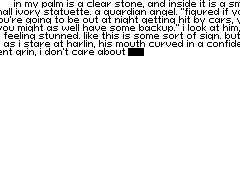

In [17]:
generated[0][0].to_PIL()[0]

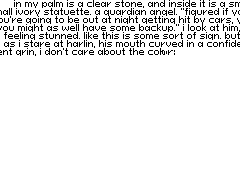

In [14]:
generated[0][2].to_PIL()[0]

In [19]:
generated[0][1]

'signs'

In [ ]:
(0.095, 0.085, 0.095, 0.4)  # best for 85M model

In [39]:
eva = evaluate_babi(generated, vocab)

100%|██████████| 5153/5153 [23:11<00:00,  3.70it/s]


In [ ]:
print(eva)

In [40]:
print(eva)

{'paddleocr': 0.11274985445371628, 'tesseract': 0.10304676887250146, 'union': 0.12090044634193674, 'readability': 0.21016883368911313}


In [34]:
print(eva)

{'paddleocr': 0.12458761886279837, 'tesseract': 0.13137977876964874, 'union': 0.13758975354162623, 'readability': 0.6722297690665632}
